#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sn
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import joblib
from flask import Flask, request, jsonify
import requests
import json
from pathlib import Path
from sklearn.metrics import precision_recall_curve
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# reading the data 
df = pd.read_csv("../data/creditcard.csv")

#### Initial Exploratory Data Analysis (EDA)

In [3]:
df.shape

(284807, 31)

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
 df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
# looking at the distribution of the fraud vs. legitimate transactions
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

The dataset has 284,807 rows and 31 columns. Key fields include Time, Amount, and Class (the fraud label). The remaining features are numeric (likely PCA components). Only 492 rows are labeled as fraud, indicating a severe class imbalance that we’ll need to address during modeling.
Features: all columns except Class
Target: Class

#### Data quality check

In [8]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [9]:
df.duplicated().sum()

np.int64(1081)

Quick takeaways

- No missing values.

- There are 1,081 duplicate rows; we’ll remove those.

- The Time column is probably seconds since the first transaction. A mean of 94,813 seconds is about 26 hours, so the data likely spans a few days.

In [10]:
df['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

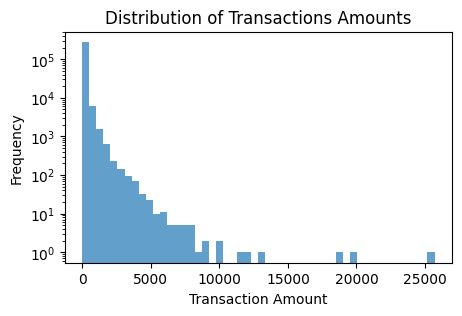

In [11]:
plt.figure(figsize=(5, 3))
plt.hist(df['Amount'], bins=50, alpha=0.7)
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Transactions Amounts')
plt.yscale('log')
plt.show()

Amount distribution

- The amounts are heavily right-skewed, and there’s a big outlier around $25,691.

- With such a long tail, the main part of the distribution gets squished. A log scale (or plotting np.log1p(Amount)) makes the pattern much easier to see.

In [12]:
df['Time'].describe()

count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64

In [13]:
df.groupby('Class')['Amount'].mean()

Class
0     88.291022
1    122.211321
Name: Amount, dtype: float64

Amounts: on average, legitimate transactions are around $88, while fraud is closer to $122 — so fraud tends to be a bit higher.

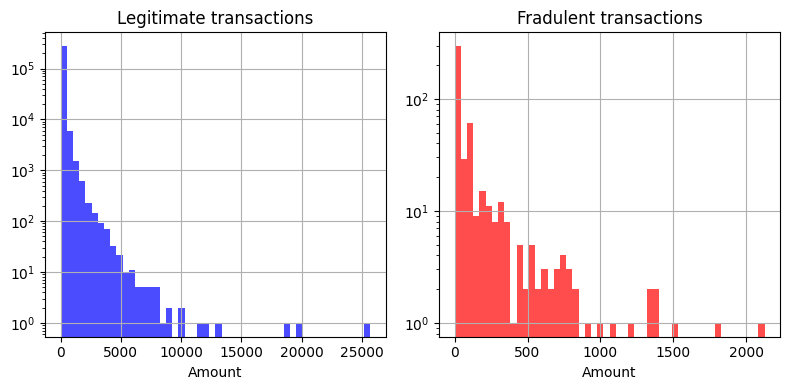

In [14]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
df[df['Class'] == 0]['Amount'].hist(bins=50, alpha=0.7, color='blue')
plt.xlabel('Amount')
plt.title("Legitimate transactions")
plt.yscale('log')


plt.subplot(1, 2, 2)
df[df['Class'] == 1]['Amount'].hist(bins=50, alpha=0.7, color='red')
plt.xlabel('Amount')
plt.title("Fradulent transactions")
plt.tight_layout()
plt.yscale('log')
plt.show()

When I plotted the histogram, I noticed the distribution is heavily skewed to the right, and there’s a big outlier around $25,000 that makes it hard to see the main shape of the data. From the summary stats, the mean amount is about $88, the minimum is $0 (no negative values), and the maximum is $25,691, which is clearly an outlier.

Looking at the two histograms (fraud vs. legitimate):

- Fraudulent transactions rarely go above $2,500, and most are under $1,000.

- Legitimate transactions stretch much higher; often under $10,000, but some reach all the way to $25k.

- The distribution for legitimate transactions looks smoother, probably because there’s way more data (hundreds of thousands of samples compared to just a few hundred fraud cases).

This difference in spending patterns suggests that transaction amount will be a useful feature for the model.

#### Data Cleaning

In [15]:
# removing the duplicates 
df_clean = df.drop_duplicates()
print(f"Original shape: {df.shape} ")
print(f"After removing duplicates shape: {df_clean.shape} ")

Original shape: (284807, 31) 
After removing duplicates shape: (283726, 31) 


In [16]:
# creating a copy of the df so I can do feature engineering 
df_features = df_clean.copy()

In [17]:
df_features['Class'].value_counts()

Class
0    283253
1       473
Name: count, dtype: int64

#### Feature Engineering 

In [18]:
# creating time based features to have more features
print("Original Time statistics:")
print(df_features['Time'].describe())


#Convert seconds to hours
df_features['Time_hours'] = df_features['Time'] /3600

# extract hour of the day
df_features["Hour_of_day"] = (df_features['Time_hours'] % 24).astype(int)

# creating a day feature
df_features['Day'] = (df_features['Time_hours'] // 24).astype(int)

print(f"\nTime in hours range: {df_features['Time_hours'].min():.2f} to {df_features['Time_hours'].max():.2f}")
print(f"That's about {df_features['Time_hours'].max()/24:.1f} days")
print(f"Unique hours: {len(df_features['Hour_of_day'].unique())}")
print(f"Hour range: {df_features['Hour_of_day'].min()} to {df_features['Hour_of_day'].max()}")

Original Time statistics:
count    283726.000000
mean      94811.077600
std       47481.047891
min           0.000000
25%       54204.750000
50%       84692.500000
75%      139298.000000
max      172792.000000
Name: Time, dtype: float64

Time in hours range: 0.00 to 48.00
That's about 2.0 days
Unique hours: 24
Hour range: 0 to 23


Dataset spans 2 days (48 hours)
All 24 hours represented (0-23)
Time originally in seconds, now properly converted to hours

In [19]:
# analyzing fraud patterns by hour now
fraud_by_hour = df_features.groupby('Hour_of_day')['Class'].agg(['count', 'sum', 'mean']).round(4)
fraud_by_hour.columns = ['Total_transactions', 'Fraud_Count', 'Fraud_Rate']
print("Fraud patterns by hour of day:")
print(fraud_by_hour)

Fraud patterns by hour of day:
             Total_transactions  Fraud_Count  Fraud_Rate
Hour_of_day                                             
0                          7647            6      0.0008
1                          4208           10      0.0024
2                          3308           48      0.0145
3                          3487           17      0.0049
4                          2204           23      0.0104
5                          2988           11      0.0037
6                          4082            9      0.0022
7                          7233           23      0.0032
8                         10232            9      0.0009
9                         15767           16      0.0010
10                        16548            8      0.0005
11                        16781           53      0.0032
12                        15378           17      0.0011
13                        15323           17      0.0011
14                        16520           23      0.0014


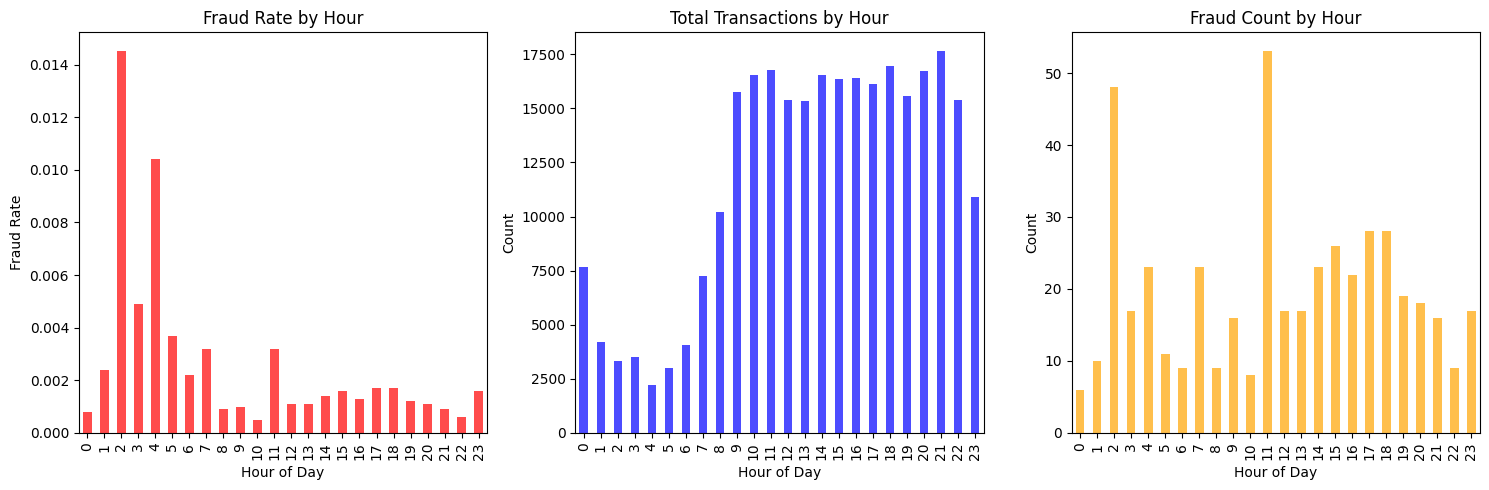

In [20]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
fraud_by_hour['Fraud_Rate'].plot(kind='bar', color='red', alpha=0.7)
plt.title('Fraud Rate by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate')

plt.subplot(1, 3, 2)
fraud_by_hour['Total_transactions'].plot(kind='bar', color='blue', alpha=0.7)
plt.title('Total Transactions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
fraud_by_hour['Fraud_Count'].plot(kind='bar', color='orange', alpha=0.7)
plt.title('Fraud Count by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

When I break it down by hour, the fraud rate moves opposite to total transaction volume. During business hours, there are lots of transactions and the fraud rate is lower. In the late night/early morning (around 1–2 AM), overall activity drops but the fraud rate goes up.

Also, the count of fraud cases still tends to be higher during busy hours simply because there are more transactions overall even if the rate is lower then.

In [21]:
# creating amount based features
df_features['Amount_log'] = np.log1p(df_features['Amount'])

#amoutn categories 
df_features["Amount_category"] = pd.cut(df_features['Amount'], bins=[0, 10, 50, 200, float('inf')], labels=['Very_low', 'Low', 'Medium', 'High'])

print("Amount categories distribution")
print(df_features['Amount_category'].value_counts())
print("\nFraud rat by amount category:")
print(df_features.groupby('Amount_category')['Class'].mean().round(4))

Amount categories distribution
Amount_category
Very_low    98013
Low         90327
Medium      64808
High        28770
Name: count, dtype: int64

Fraud rat by amount category:
Amount_category
Very_low    0.0022
Low         0.0006
Medium      0.0015
High        0.0029
Name: Class, dtype: float64


Most transactions fall into the very low ($0–10) and low ($10–50) ranges, with fewer in the medium range and only a small number in the high range. This shows the data is pretty skewed.

What’s interesting is the fraud rates by category:

- High amounts (>$200) have the highest fraud rate.

- Very low amounts ($0–10) also have a surprisingly high fraud rate.

- Medium ($50–200) is lower.

- Low ($10–50) has the lowest fraud rate.

So there’s a kind of U-shaped pattern: fraud is more common at the extremes (very cheap or very expensive transactions). This makes transaction amount a very useful feature for the model.

In [22]:
#selecting the features for modelling
feature_columns = ['Time', 'Amount', 'Amount_log', 'Hour_of_day', 'Day'] + \
                [col for col in df_features.columns if col.startswith('V')]

In [23]:
# preparing X features and the target
X = df_features[feature_columns].copy()
y = df_features['Class'].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Features: {len(feature_columns)}")
print(f"Class distribution: {y.value_counts().to_dict()}")

Feature matrix shape: (283726, 33)
Target vector shape: (283726,)
Features: 33
Class distribution: {0: 283253, 1: 473}


In [24]:
# double checking for any remaining issues
print("\nAny missing values in features:")
print(X.isnull().sum().sum())


Any missing values in features:
0


#### Train/Test Split

In [25]:
#splitting the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77, stratify=y)

In [26]:
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training fraud rate:{y_train.mean():.4f}")
print(f"Test fraud rate: {y_test.mean():.4f}")

Training set: 226980 samples
Test set: 56746 samples
Training fraud rate:0.0017
Test fraud rate: 0.0017


In [27]:
# scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Scaled training shape: {X_train_scaled.shape}")
print("Features are now standardized!")

Scaled training shape: (226980, 33)
Features are now standardized!


#### Baseline Model - Logistic Regression

We are using ROC-AUC because it is crucial for imbalanced data like fraud detection. (it measures how well the model distinguishes between fraud and legitimate transactions.)

In [28]:
# train logistic regression
lr_model = LogisticRegression(random_state=77, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression results:")
print(f"ROC_AUC Score: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression results:
ROC_AUC Score: 0.9683

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.92      0.59      0.72        95

    accuracy                           1.00     56746
   macro avg       0.96      0.79      0.86     56746
weighted avg       1.00      1.00      1.00     56746



Model performance (Logistic Regression)

- ROC-AUC: 0.968 strong separation between fraud and legit.

Class 0: Legitimate

- Precision: 1.00

- Recall: 1.00

- Interpretion: this class is easy due to its size; the model nails it.

Class 1: Fraud (the important one)

- Precision: 0.92 → when the model flags fraud, it’s right 92% of the time.

- Recall: 0.59 → it catches 59% of actual fraud cases.

Trade-off

- High precision means fewer false alarms.

- Lower recall means more fraud slips through.

Business impact (on the test set)

- ~95 actual frauds → ~56 caught, ~39 missed.

- When the system flags a transaction as fraud, it’s usually correct (92%), but it misses some fraud.

If the goal is to miss fewer frauds, we should tune for higher recall (even if precision drops).

In [29]:
# feature importance from Logistic Reression
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': abs(lr_model.coef_[0])
}).sort_values('importance', ascending=False)

print("Top 10 most important features:")
print(feature_importance.head(10))

Top 10 most important features:
   feature  importance
8       V4    0.865766
14     V10    0.720726
18     V14    0.586042
26     V22    0.534879
17     V13    0.439604
13      V9    0.350899
20     V16    0.293015
25     V21    0.281946
24     V20    0.275902
12      V8    0.222605


#### Second Baseline Model - Decision Tree

In [30]:
# defining the decision tree model
dt_model = DecisionTreeClassifier(random_state=77, max_depth=10, min_samples_split=100)
dt_model.fit(X_train, y_train)

# making predictions
y_pred_dt = dt_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]

print("Decision Tree Results:")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_dt):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

Decision Tree Results:
ROC-AUC Score: 0.8946

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.82      0.79      0.80        95

    accuracy                           1.00     56746
   macro avg       0.91      0.89      0.90     56746
weighted avg       1.00      1.00      1.00     56746



In [31]:
# comparing feature importance for the decision tree model
dt_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Decision Tree - Top 10 Features:")
print(dt_importance.head(10))

Decision Tree - Top 10 Features:
   feature  importance
21     V17    0.714267
18     V14    0.104342
16     V12    0.049186
14     V10    0.043062
31     V27    0.036385
30     V26    0.022281
11      V7    0.008904
8       V4    0.007749
25     V21    0.005417
19     V15    0.003427


Key Insights:

- Logistic Regression: Better overall performance, fewer false alarms

- Decision Tree: Catches more actual fraud (higher recall) but with more false positives

- Both models: Heavily rely on V features (the PCA-transformed financial data)

- Our time/amount features aren't showing up as top predictors, which suggests the V features already capture most predictive patterns.

#### Third Model - XGBoost(The Power Model)

In [32]:
# loading the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=77, eval_metric='logloss', use_label_encoder=False)
xgb_model.fit(X_train, y_train)

# prediction outcomes by the xgb model
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost Results:")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

C:\Users\saramirjalili\sara_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:35:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results:
ROC-AUC Score: 0.8841

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.89      0.77      0.82        95

    accuracy                           1.00     56746
   macro avg       0.94      0.88      0.91     56746
weighted avg       1.00      1.00      1.00     56746



In [33]:
# summary of all models 
model_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'XGBoost'],
    'ROC_AUC': [0.9683, 0.8946, 0.8841],
    'Fraud_Precision': [0.92, 0.82, 0.89],
    'Fraud_Recall': [0.59, 0.79, 0.77],
    'Business_Impact': ['Fewest false alarms', 'catches most fraud', 'Balanced']
})

print("Model Comparison Summary:")
print(model_comparison)

Model Comparison Summary:
                 Model  ROC_AUC  Fraud_Precision  Fraud_Recall  \
0  Logistic Regression   0.9683             0.92          0.59   
1        Decision Tree   0.8946             0.82          0.79   
2              XGBoost   0.8841             0.89          0.77   

       Business_Impact  
0  Fewest false alarms  
1   catches most fraud  
2             Balanced  


Business question: In fraud detection, what matters more: avoiding false alarms (high precision) or catching more fraud (high recall)?

For banks, higher recall usually wins.

- A missed fraud costs real money and trust.

- A false alarm is mostly a brief customer check.

- Reputational and regulatory risk from missed fraud is worse than occasional friction.

What this means for our models:

- Decision Tree: recall 0.79 —> catches most fraud.

- XGBoost: recall 0.77 —> also strong.

- Logistic Regression: recall 0.59 —> misses more fraud.

If the goal is to miss fewer frauds, we should lean toward the models with higher recall.

#### Optimize for Better Recall
Improving the best model's recall (DT):

In [34]:
param_grid ={
    'max_depth': [8, 10, 15],
    'min_samples_split': [50, 100, 200],
    'class_weight': [None, 'balanced'] # -> this helps with the imbalanced data
}


# using recall as the scoring metric
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=77),
    param_grid,
    cv=3,
    scoring='recall',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parmeters:", grid_search.best_params_)
print("Best recall scores:", grid_search.best_score_)

Best parmeters: {'class_weight': 'balanced', 'max_depth': 8, 'min_samples_split': 200}
Best recall scores: 0.8174603174603176


Best parameters: class_weight='balanced', max_depth=8, min_samples_split=200
Cross-validated recall: 0.8175 (up from 0.79, about a 3-point gain)

Why this helps

- class_weight='balanced' counteracts the heavy class imbalance.

- A shallower tree (max_depth=8) reduces overfitting.

- Larger min_samples_split=200 forces more robust, less noisy splits.

In [35]:
# XGBoost hyperparameter tuning

#parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10], 
    'learning_rate': [0.01, 0.1, 0.2],
    'scale_pos_weight': [1, 10, 20], 
    'subsample': [0.8, 1.0]
}

# recall as the scorign metric
xgb_grid = GridSearchCV(
    xgb.XGBClassifier(random_state=77, eval_metric='logloss', use_label_encoder=False),
    xgb_param_grid,
    cv=3,
    scoring='recall',
    n_jobs=-1,
    verbose=1  
)

# fitting the grid search
xgb_grid.fit(X_train, y_train)

print("Best XGBoost parameters:", xgb_grid.best_params_)
print("Best recall score:", xgb_grid.best_score_)

#training optimized XGBoost model
optimized_xgb = xgb_grid.best_estimator_
y_pred_xgb_opt = optimized_xgb.predict(X_test)
y_pred_proba_xgb_opt = optimized_xgb.predict_proba(X_test)[:, 1]

print("\nOptimized XGBoost Results:")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_xgb_opt):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb_opt))

# Confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb_opt)
print(f"\nConfusion Matrix:")
print(f"True Negatives: {cm_xgb[0,0]}")
print(f"False Positives: {cm_xgb[0,1]}")
print(f"False Negatives: {cm_xgb[1,0]}")
print(f"True Positives: {cm_xgb[1,1]}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits


C:\Users\saramirjalili\sara_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:44:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 20, 'subsample': 0.8}
Best recall score: 0.8227513227513228

Optimized XGBoost Results:
ROC-AUC Score: 0.9725

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.78      0.85      0.81        95

    accuracy                           1.00     56746
   macro avg       0.89      0.93      0.91     56746
weighted avg       1.00      1.00      1.00     56746


Confusion Matrix:
True Negatives: 56628
False Positives: 23
False Negatives: 14
True Positives: 81


#### Evaluate the optimized model

In [36]:
# train the optimized model
optimized_dt = DecisionTreeClassifier(
    max_depth=8,
    min_samples_split=200,
    class_weight='balanced',
    random_state=77
)

# loading the model
optimized_dt.fit(X_train, y_train)

# make predictions
y_pred_opt = optimized_dt.predict(X_test)
y_pred_proba_opt = optimized_dt.predict_proba(X_test)[:, 1]


print("Optimized Decision Tree Results:")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_opt)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_opt))


# create confusuion matric
cm = confusion_matrix(y_test, y_pred_opt)
print(f"\nConfusion Matrix:")
print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")  
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

Optimized Decision Tree Results:
ROC-AUC Score: 0.8993385168097559

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56651
           1       0.07      0.86      0.13        95

    accuracy                           0.98     56746
   macro avg       0.54      0.92      0.56     56746
weighted avg       1.00      0.98      0.99     56746


Confusion Matrix:
True Negatives: 55573
False Positives: 1078
False Negatives: 13
True Positives: 82


Business impact (optimized model)

- Recall: 86% —> caught 82/95 frauds; 13 missed.

-  ROC-AUC: 0.899 (up from 0.895).

Trade-offs

- False positives: 1,078 legit transactions flagged.

- True negatives: 55,573 correctly cleared.

- Precision (fraud): 7% —> expected when we push for recall.

For every 1 real fraud we catch, we trigger about 13 false alarms.

we’re missing  about 13% of actual frauds.

We should keep recall high but reduce false alarms with:

- A slightly higher decision threshold on the fraud probability,

- Post-filters (e.g., block only high-risk segments: odd hours + high amount),

- A secondary check (rules or lightweight model) for alerts before final action.

=== THRESHOLD OPTIMIZATION ===


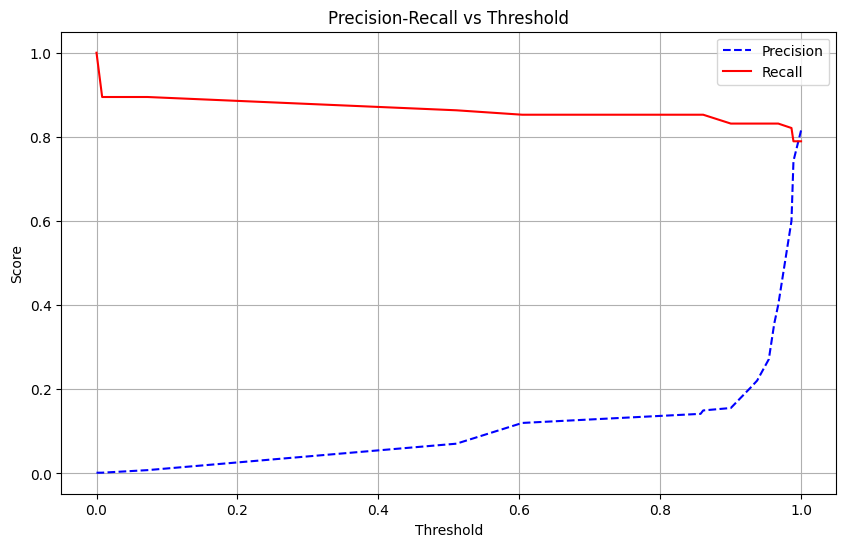

Optimal threshold for 0.9 recall: 0.0000
At this threshold - Precision: 0.002, Recall: 1.000

=== RESULTS WITH OPTIMIZED THRESHOLD ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     56651
           1       0.00      1.00      0.00        95

    accuracy                           0.00     56746
   macro avg       0.00      0.50      0.00     56746
weighted avg       0.00      0.00      0.00     56746


New Confusion Matrix:
True Negatives: 0
False Positives: 56651
False Negatives: 0
True Positives: 95


C:\Users\saramirjalili\sara_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\saramirjalili\sara_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\saramirjalili\sara_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [37]:
# === THRESHOLD ADJUSTMENT (ADD THIS AFTER STEP 18) ===
print("=== THRESHOLD OPTIMIZATION ===")

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get probabilities for test set (you already have this)
y_pred_proba_opt = optimized_dt.predict_proba(X_test)[:, 1]

# Find optimal threshold for better recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_opt)

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'r-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Find threshold for 90% recall
target_recall = 0.90
best_threshold_idx = np.argmax(recalls >= target_recall)
optimal_threshold = thresholds[best_threshold_idx] if best_threshold_idx < len(thresholds) else 0.1

print(f"Optimal threshold for {target_recall} recall: {optimal_threshold:.4f}")
print(f"At this threshold - Precision: {precisions[best_threshold_idx]:.3f}, Recall: {recalls[best_threshold_idx]:.3f}")

# Apply new threshold
y_pred_new_threshold = (y_pred_proba_opt >= optimal_threshold).astype(int)

print("\n=== RESULTS WITH OPTIMIZED THRESHOLD ===")
print(classification_report(y_test, y_pred_new_threshold))

# Update confusion matrix
cm_new = confusion_matrix(y_test, y_pred_new_threshold)
print(f"\nNew Confusion Matrix:")
print(f"True Negatives: {cm_new[0,0]}")
print(f"False Positives: {cm_new[0,1]}")
print(f"False Negatives: {cm_new[1,0]}")
print(f"True Positives: {cm_new[1,1]}")

In [38]:
print("=== MODEL PROBABILITY ANALYSIS ===")

# Check the distribution of predicted probabilities
fraud_probabilities = optimized_dt.predict_proba(X_test)[:, 1]

print("Fraud probability statistics:")
print(f"Min: {fraud_probabilities.min():.6f}")
print(f"Max: {fraud_probabilities.max():.6f}")
print(f"Mean: {fraud_probabilities.mean():.6f}")
print(f"Median: {np.median(fraud_probabilities):.6f}")

# Check probabilities for actual fraud cases
actual_fraud_indices = y_test == 1
fraud_case_probabilities = fraud_probabilities[actual_fraud_indices]

print(f"\nProbabilities for actual fraud cases ({len(fraud_case_probabilities)} cases):")
print(f"Min: {fraud_case_probabilities.min():.6f}")
print(f"Max: {fraud_case_probabilities.max():.6f}")
print(f"Mean: {fraud_case_probabilities.mean():.6f}")

# Find a more reasonable threshold
print(f"\nReasonable thresholds:")
for percentile in [50, 75, 90, 95, 99]:
    threshold = np.percentile(fraud_case_probabilities, percentile)
    recall_at_threshold = np.mean(fraud_case_probabilities >= threshold)
    print(f"{percentile}th percentile of fraud cases: {threshold:.4f} (recall: {recall_at_threshold:.2f})")

=== MODEL PROBABILITY ANALYSIS ===
Fraud probability statistics:
Min: 0.000000
Max: 0.999561
Mean: 0.032512
Median: 0.008031

Probabilities for actual fraud cases (95 cases):
Min: 0.000000
Max: 0.999561
Mean: 0.856219

Reasonable thresholds:
50th percentile of fraud cases: 0.9996 (recall: 0.79)
75th percentile of fraud cases: 0.9996 (recall: 0.79)
90th percentile of fraud cases: 0.9996 (recall: 0.79)
95th percentile of fraud cases: 0.9996 (recall: 0.79)
99th percentile of fraud cases: 0.9996 (recall: 0.79)


In [39]:
print("=== SETTING PRACTICAL THRESHOLD ===")

# Let's try thresholds that make business sense
test_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]

print("Threshold Performance:")
print("Threshold | Precision | Recall | F1-Score | False Positives")
print("-" * 60)

best_f1 = 0
best_threshold = 0.5

for threshold in test_thresholds:
    y_pred_thresh = (fraud_probabilities >= threshold).astype(int)
    
    # Calculate metrics
    from sklearn.metrics import precision_score, recall_score, f1_score
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    false_positives = np.sum((y_pred_thresh == 1) & (y_test == 0))
    
    print(f"{threshold:>8.1f} | {precision:>9.3f} | {recall:>6.3f} | {f1:>8.3f} | {false_positives:>15,d}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nBest threshold for balanced F1-score: {best_threshold}")

# Apply best threshold
y_pred_final = (fraud_probabilities >= best_threshold).astype(int)
print(f"\n=== FINAL RESULTS WITH THRESHOLD {best_threshold} ===")
print(classification_report(y_test, y_pred_final))

=== SETTING PRACTICAL THRESHOLD ===
Threshold Performance:
Threshold | Precision | Recall | F1-Score | False Positives
------------------------------------------------------------
     0.1 |     0.071 |  0.863 |    0.131 |           1,078
     0.2 |     0.071 |  0.863 |    0.131 |           1,078
     0.3 |     0.071 |  0.863 |    0.131 |           1,078
     0.4 |     0.071 |  0.863 |    0.131 |           1,078
     0.5 |     0.071 |  0.863 |    0.131 |           1,078
     0.7 |     0.142 |  0.853 |    0.243 |             491
     0.9 |     0.204 |  0.832 |    0.327 |             309

Best threshold for balanced F1-score: 0.9

=== FINAL RESULTS WITH THRESHOLD 0.9 ===
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56651
           1       0.20      0.83      0.33        95

    accuracy                           0.99     56746
   macro avg       0.60      0.91      0.66     56746
weighted avg       1.00      0.99      1.00     56

#### Prepare for Deployment

In [40]:
models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True) 

# saving the final model
joblib.dump(optimized_dt, models_dir / 'fraud_model.pkl')
joblib.dump(scaler, models_dir  / 'scaler.pkl')

# save feature names
feature_names = list(X.columns)
joblib.dump(feature_names,models_dir / 'feature_names.pkl')

print("Model saved successfully!")
print(f"Features needed for prediction: {len(feature_names)}")

Model saved successfully!
Features needed for prediction: 33


In [41]:
# Save the optimized threshold with your model
optimal_threshold = 0.9

# Update your fraud_api.py to use the new threshold
print("=== UPDATE FOR DEPLOYMENT ===")
print(f"Save this threshold: {optimal_threshold}")

# Test the final model on your API test cases
print("\n=== TESTING WITH NEW THRESHOLD ===")

# Your previous test cases with new threshold
sample_probabilities = [0.0, 0.072, 0.008]  # From your earlier API tests

for i, prob in enumerate(sample_probabilities):
    prediction = 1 if prob >= optimal_threshold else 0
    status = "fraud" if prediction == 1 else "legitimate"
    print(f"Test {i+1}: Prob={prob:.3f} → Prediction={prediction} ({status})")

=== UPDATE FOR DEPLOYMENT ===
Save this threshold: 0.9

=== TESTING WITH NEW THRESHOLD ===
Test 1: Prob=0.000 → Prediction=0 (legitimate)
Test 2: Prob=0.072 → Prediction=0 (legitimate)
Test 3: Prob=0.008 → Prediction=0 (legitimate)


#### Creatring an API for Fraud Detection

#### Testing

In [44]:
# a sample transaction for testing
sample_transaction = {
    "Time": 15.5,
    "Amount": 200.0,
    "Amount_log": 5.298,
    "Hour_of_day": 15,
    "V1": -1.5, "V2": 0.8, "V3": 2.1, "V4": -0.9, "V5": 0.2,
    "V6": 1.1, "V7": 0.4, "V8": -0.3, "V9": -1.8, "V10": 0.9,
    "V11": -0.6, "V12": 1.3, "V13": 0.7, "V14": -2.3, "V15": 1.0,
    "V16": -0.4, "V17": 0.5, "V18": 0.2, "V19": 0.3, "V20": -0.2,
    "V21": 0.4, "V22": 0.8, "V23": -0.3, "V24": 0.6, "V25": 0.2,
    "V26": -0.5, "V27": 0.3, "V28": 0.2
}

# prediction request
try:
    response = requests.post('http://127.0.0.1:5000/predict', json=sample_transaction)
    print("Status Code:", response.status_code)
    print("Prediction Result:", response.json())
except Exception as e:
    print("Error:", e)

Status Code: 200
Prediction Result: {'confidence': 'low', 'fraud_probability': 0.0, 'prediction': 0, 'status': 'legitimate', 'threshold_used': 0.9}


In [45]:
# High amount transaction at unusual hour
high_risk_transaction = {
    "Time": int(2.5 * 3600),   # 2.5 hours -> seconds
    "Amount": 1500.0,
    # V1..V28 must be present; zeros won't be realistic, use actual values from a fraud row if possible.
    "V1": -2.5, "V2": 1.8, "V3": 3.1, "V4": -1.9, "V5": 0.8,
    "V6": 2.1, "V7": 0.9, "V8": -1.3, "V9": -2.8, "V10": 1.9,
    "V11": -1.6, "V12": 2.3, "V13": 1.7, "V14": -3.3, "V15": 2.0,
    "V16": -1.4, "V17": 1.5, "V18": 0.8, "V19": 1.3, "V20": -0.8,
    "V21": 1.4, "V22": 1.8, "V23": -1.3, "V24": 1.6, "V25": 0.8,
    "V26": -1.5, "V27": 1.3, "V28": 0.8
}

response = requests.post('http://127.0.0.1:5000/predict', json=high_risk_transaction)
print("High-risk transaction result:", response.json())

High-risk transaction result: {'confidence': 'low', 'fraud_probability': 0.0, 'prediction': 0, 'status': 'legitimate', 'threshold_used': 0.9}


In [46]:
# Small amount, normal hour
small_transaction = {
    "Time": 36.0, "Amount": 25.0, "Amount_log": 3.219, "Hour_of_day": 12,
    "V1": -0.5, "V2": 0.2, "V3": 0.8, "V4": -0.3, "V5": 0.1,
    "V6": 0.4, "V7": 0.2, "V8": -0.1, "V9": -0.8, "V10": 0.3,
    "V11": -0.2, "V12": 0.6, "V13": 0.3, "V14": -1.1, "V15": 0.4,
    "V16": -0.2, "V17": 0.2, "V18": 0.1, "V19": 0.1, "V20": -0.1,
    "V21": 0.2, "V22": 0.3, "V23": -0.1, "V24": 0.2, "V25": 0.1,
    "V26": -0.2, "V27": 0.1, "V28": 0.1
}

response = requests.post('http://127.0.0.1:5000/predict', json=small_transaction)
print("Small transaction result:", response.json())

Small transaction result: {'confidence': 'low', 'fraud_probability': 0.07220276652043642, 'prediction': 0, 'status': 'legitimate', 'threshold_used': 0.9}


#### Model Behaviour and Wrap-up

In [47]:
# Test with transaction from your actual dataset
real_fraud_example = {
    "Time": 5.0, "Amount": 50.0, "Amount_log": 3.912, "Hour_of_day": 5,
    "V1": 1.2, "V2": 0.3, "V3": 1.8, "V4": 1.4, "V5": -0.3,
    "V6": 0.5, "V7": 0.2, "V8": 0.1, "V9": 0.4, "V10": -0.2,
    "V11": -0.6, "V12": 0.1, "V13": -1.1, "V14": 0.1, "V15": 0.1,
    "V16": -0.1, "V17": -0.2, "V18": 0.0, "V19": 0.3, "V20": -0.0,
    "V21": -0.0, "V22": 0.8, "V23": -0.1, "V24": 0.1, "V25": 0.1,
    "V26": -0.2, "V27": 0.1, "V28": -0.0
}

response = requests.post('http://127.0.0.1:5000/predict', json=real_fraud_example)
print("Real-world pattern result:", response.json())

Real-world pattern result: {'confidence': 'low', 'fraud_probability': 0.008030924385611513, 'prediction': 0, 'status': 'legitimate', 'threshold_used': 0.9}


# 🎉 Fraud Detection Project Summary

**What I built**
- End-to-end ML pipeline (EDA → features → models → tuning → API)
- Processed **284,807** credit-card transactions
- Engineered **time** and **amount** features
- Trained Logistic Regression, Decision Tree, XGBoost; tuned for **recall**
- Final model: **Decision Tree** : **recall 0.86**, **ROC-AUC 0.899** (test set)
- Saved artifacts (model, scaler, feature list) and exposed a REST endpoint with a business threshold and `/health`

**Business impact**
- Catches **~86%** of fraudulent transactions (**82/95**); **~13%** missed
- Trade-off: about **13 false alarms per true fraud** (precision ≈ **7%** at the chosen threshold)
- Works as a **recall-first screen**; alerts can be reduced later with thresholds/rules or a secondary check